In [ ]:
def preprocess_and_fill_missing(df, target_column, val_size=0.2):
    # Sélectionner les colonnes catégorielles (de type 'object' ou 'category') dans le DataFrame
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Retirer la colonne cible des colonnes catégorielles (car elle ne doit pas être encodée)
    categorical_columns.remove(target_column)

    # Appliquer la fonction pd.get_dummies pour encoder les colonnes catégorielles en variables indicatrices
    encoded_df = pd.get_dummies(df[categorical_columns], drop_first=True)

    # Remplacer les colonnes catégorielles d'origine par les colonnes encodées dans le DataFrame
    data = df.drop(columns=categorical_columns).join(encoded_df)

    # Créer un masque pour identifier les valeurs manquantes dans la colonne cible
    missing_mask = data[target_column].isnull()

    # Séparer les données en ensembles d'entraînement (sans valeurs manquantes) et de test (avec valeurs manquantes)
    X_train = data[~missing_mask].drop(target_column, axis=1)
    y_train = data[~missing_mask][target_column]
    X_test = data[missing_mask].drop(target_column, axis=1)

    # Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=val_size
    )
    #print(f"Distribution des classes {target_column}  train:\n{y_train_split.value_counts()}\n")
    #print(f"Distribution des classes  {target_column}  val:\n{y_val_split.value_counts()}\n\n")

    # Entraîner un modèle de classification (Random Forest)
    model = RandomForestClassifier()
    model.fit(X_train_split, y_train_split)

    # Prédire les valeurs manquantes dans la colonne cible
    predictions = model.predict(X_test)

    # Remplacer les valeurs manquantes par les prédictions obtenues
    data.loc[missing_mask, target_column] = predictions

    # Calculer l'exactitude du modèle sur l'ensemble de validation
    accuracy_val = accuracy_score(y_val_split, model.predict(X_val_split))
    #print(f"Validation Accuracy of the model {target_column}: {accuracy_val:.2f}")

    return data

In [ ]:
def preprocessing(data, cols_to_drop):
    # Supprimer les colonnes inutiles ou non pertinentes
    df_cleaned = data.drop(columns=cols_to_drop)

    # Sélectionner les colonnes numériques (de type 'float64' et 'int64')
    numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Normaliser les colonnes numériques en utilisant StandardScaler
    # scaler = StandardScaler()
    # df_cleaned[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Normaliser les colonnes numériques en utilisant MinMaxScaler pour les ramener entre 0 et 1
    scaler = MinMaxScaler()
    df_cleaned[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Identifier les colonnes contenant uniquement les valeurs 'Yes' et 'No'
    yes_no_columns = [col for col in df_cleaned.columns if df_cleaned[col].isin(['Yes', 'No']).all()]

    # Initialiser un label encoder pour convertir les colonnes 'Yes' et 'No' en 0 et 1
    label_encoder = LabelEncoder()
    for col in yes_no_columns:
        df_cleaned[col] = label_encoder.fit_transform(df_cleaned[col])

    # Identifier les colonnes catégorielles restantes
    categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()

    # Obtenir une liste des colonnes avec des valeurs manquantes
    columns_with_missing_values = df_cleaned.columns[df_cleaned.isnull().any()]

    # Initialiser une liste pour stocker les DataFrames après traitement des valeurs manquantes
    processed_dfs = []

    # Parcourir chaque colonne ayant des valeurs manquantes
    for col in columns_with_missing_values:
        # Créer un DataFrame temporaire avec uniquement la colonne à traiter
        temp_df = df_cleaned.drop([c for c in columns_with_missing_values if c != col ], axis=1)

        # Appliquer la fonction preprocess_and_fill_missing pour combler les valeurs manquantes
        preprocessed_df = preprocess_and_fill_missing(temp_df, col)

        # Ajouter le DataFrame traité à la liste
        processed_dfs.append(preprocessed_df)

    # Combiner tous les DataFrames traités en un seul
    final_df = processed_dfs[0]
    for df in processed_dfs[1:]:
        final_df = final_df.combine_first(df)

    # Supprimer les doublons s'il y en a
    if final_df.duplicated().sum() > 0:
        final_df = final_df.drop_duplicates()

    # Rechercher à nouveau les colonnes catégorielles après traitement
    categorical_columns = final_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Encoder les colonnes catégorielles avec get_dummies
    encoded_df = pd.get_dummies(final_df[categorical_columns], drop_first=False)

    # Remplacer les colonnes catégorielles d'origine par les colonnes encodées
    df = final_df.drop(columns=categorical_columns).join(encoded_df)

    # Identifier les colonnes de type booléen et les convertir en entiers (0 ou 1)
    bool_columns = df.select_dtypes(include='bool').columns
    df[bool_columns] = df[bool_columns].astype(int)

    return df

In [ ]:
def feature_selection_with_random_forest(df, target_column):
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Train a Random Forest model to assess feature importance
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Use SelectFromModel to select features based on importance
    selector = SelectFromModel(rf, threshold="mean", prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Print selected features
    selected_features = X.columns[selector.get_support()]
    print(f"Selected features: {list(selected_features)}")

    return X_train_selected, X_test_selected, y_train, y_test

In [ ]:
def apply_smote(X_train, X_test, y_train, y_test):

    # Initialiser SMOTE
    smote = SMOTE(random_state=42)

    # Appliquer SMOTE pour générer des exemples synthétiques pour la classe minoritaire
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print(f"Distribution des classes avant SMOTE :\n{y_train.value_counts()} \n")
    print(f"Distribution des classes après SMOTE :\n{pd.Series(y_train_resampled).value_counts()}\n")

    return X_train_resampled, X_test, y_train_resampled, y_test

In [ ]:
def test_balanced_sample(X_test, y_test):
    # Appliquer le sous-échantillonnage pour équilibrer l'échantillon de test
    sampler = RandomUnderSampler()
    churn_label_counts = y_test.value_counts()
    print("Original class distribution:")
    print(churn_label_counts)

    # Appliquer la méthode d'équilibrage sur les données de test
    X_test_balanced, y_test_balanced = sampler.fit_resample(X_test, y_test)
    churn_label_counts = y_test_balanced.value_counts()
    print("Balanced class distribution:")
    print(churn_label_counts)

    return X_test_balanced, y_test_balanced

In [ ]:
def feature_selection_with_mutual_info(df, target_column, num_features):
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Apply mutual information-based feature selection
    mi_selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_selected = mi_selector.fit_transform(X, y)

    # Get selected features
    selected_features = X.columns[mi_selector.get_support()]
    print(f"Selected features {len(list(selected_features))}: {list(selected_features)}")

    return X_selected, y

#**ML modeling** - Churn Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectFromModel
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [ ]:
path="/content/drive/MyDrive/Mlops/telco.csv"
data = pd.read_csv(path)

In [ ]:
cols_to_drop = ['Customer ID', 'Gender', 'Age','Zip Code', 'Latitude', 'Longitude','City', 'Churn Category','Churn Score','Churn Reason', 'Customer Status','Quarter','State','Country']
df=preprocessing(data,cols_to_drop)

In [ ]:
# X = df.drop(columns=['Churn Label'])
# y = df['Churn Label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Apply the function to your cleaned dataframe
X_train, X_test, y_train, y_test = feature_selection_with_random_forest(df, 'Churn Label')

Selected features: ['Avg Monthly GB Download', 'Contract_Two Year', 'Monthly Charge', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# X, y=feature_selection_with_mutual_info(df, 'Churn Label', 5)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train, X_test, y_train, y_test=apply_smote(X_train, X_test, y_train, y_test)

Distribution des classes avant SMOTE :
Churn Label
0    4141
1    1493
Name: count, dtype: int64 

Distribution des classes après SMOTE :
Churn Label
0    4141
1    4141
Name: count, dtype: int64



In [ ]:
X_test, y_test = test_balanced_sample(X_test, y_test)

Original class distribution:
Churn Label
0    1033
1     376
Name: count, dtype: int64
Balanced class distribution:
Churn Label
0    376
1    376
Name: count, dtype: int64


Training Logistic Regression...


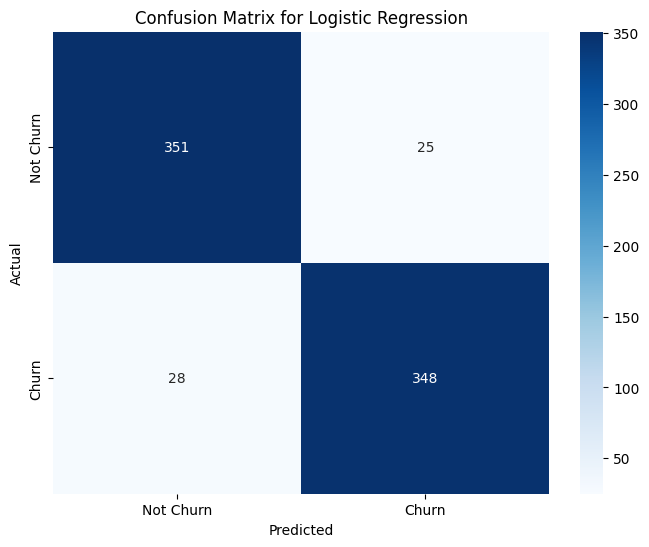

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       376
           1       0.93      0.93      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752

Training Random Forest...


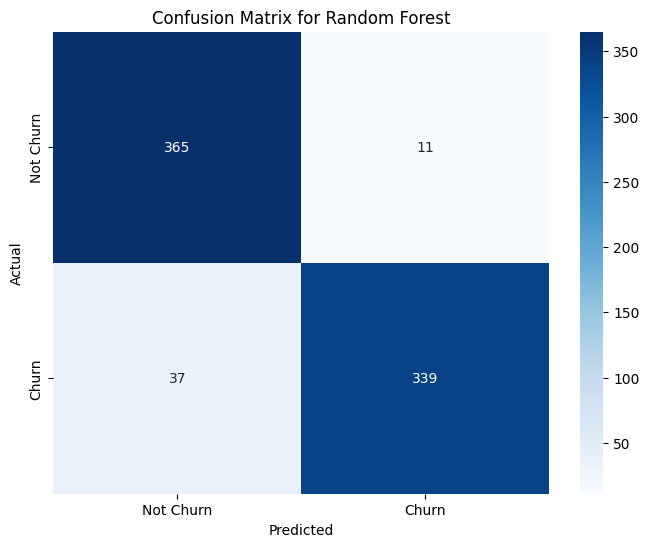

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       376
           1       0.97      0.90      0.93       376

    accuracy                           0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752

Training Support Vector Machine...


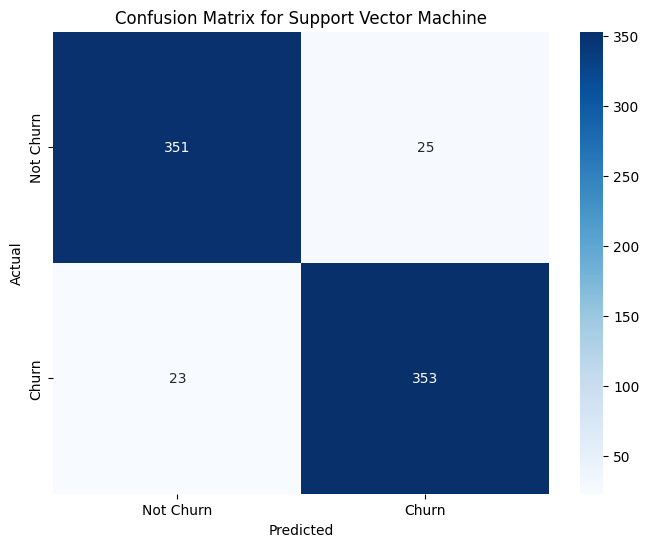

Classification Report for Support Vector Machine:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       376
           1       0.93      0.94      0.94       376

    accuracy                           0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752

Training K-Nearest Neighbors...


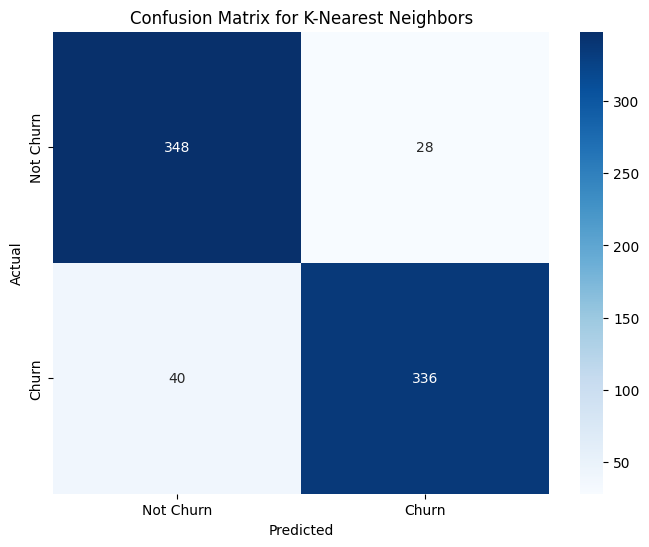

Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       376
           1       0.92      0.89      0.91       376

    accuracy                           0.91       752
   macro avg       0.91      0.91      0.91       752
weighted avg       0.91      0.91      0.91       752

Training Decision Tree...


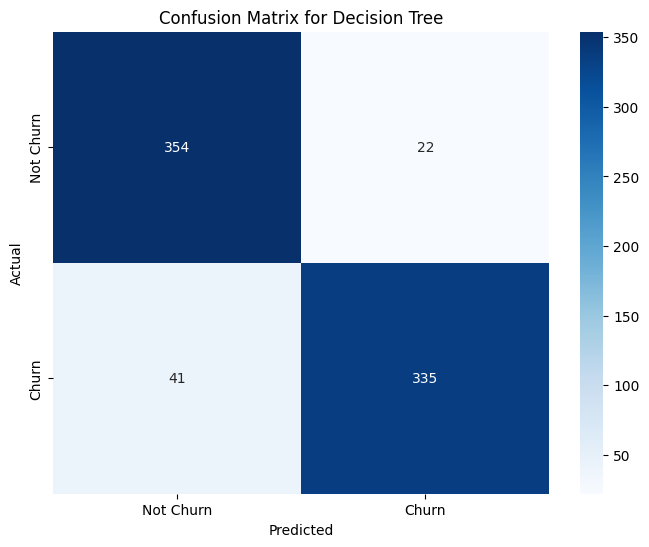

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       376
           1       0.94      0.89      0.91       376

    accuracy                           0.92       752
   macro avg       0.92      0.92      0.92       752
weighted avg       0.92      0.92      0.92       752

Training Gradient Boosting...


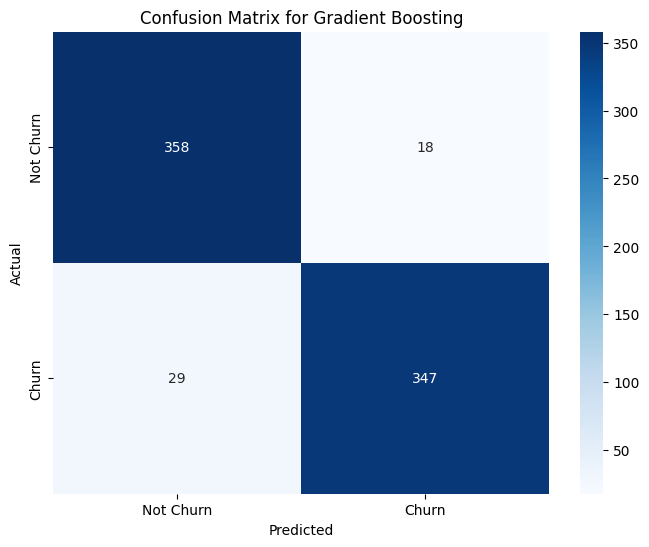

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       376
           1       0.95      0.92      0.94       376

    accuracy                           0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752

Training XGB...


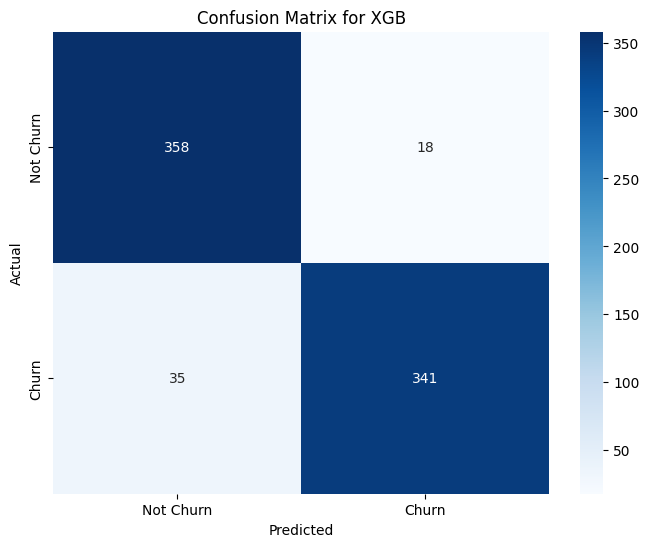

Classification Report for XGB:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       376
           1       0.95      0.91      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752

Training CatBoost...


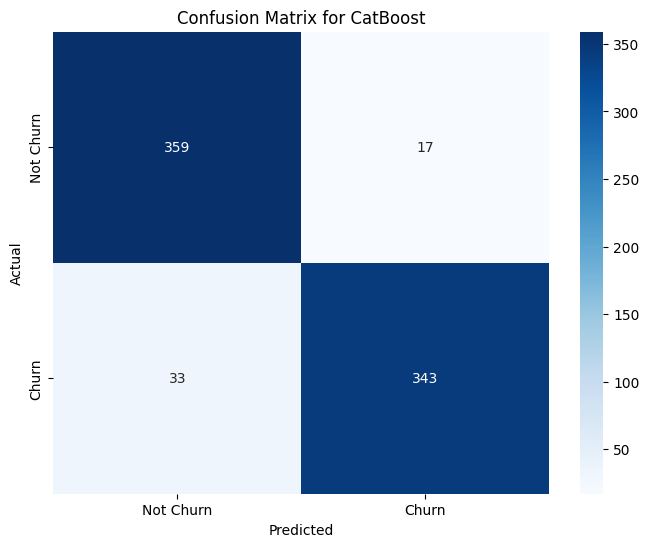

Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       376
           1       0.95      0.91      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752



,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
0,Logistic Regression,0.925622,0.929521,0.925621,0.929520
1,Random Forest,1.000000,0.936170,1.000000,0.936094
2,Support Vector Machine,0.930814,0.936170,0.930814,0.936170
3,K-Nearest Neighbors,0.963415,0.909574,0.963407,0.909551
4,Decision Tree,1.000000,0.916223,1.000000,0.916170
5,Gradient Boosting,0.954238,0.937500,0.954235,0.937487
6,XGB,0.997464,0.929521,0.997464,0.929485
7,CatBoost,0.983096,0.933511,0.983096,0.933481


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    'XGB': XGBClassifier(),
    'CatBoost':CatBoostClassifier(verbose=0)
}



# Dictionnaire pour stocker les scores
scores = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Train F1 Score": [],
    "Test F1 Score": []
}

# Boucle pour entraîner et évaluer les modèles
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Ajouter les résultats au dictionnaire
    scores["Model"].append(model_name)
    scores["Train Accuracy"].append(train_accuracy)
    scores["Test Accuracy"].append(test_accuracy)
    scores["Train F1 Score"].append(train_f1)
    scores["Test F1 Score"].append(test_f1)

    # Calculer et afficher la matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Not Churn", "Churn"],  # Remplacez par vos classes
                yticklabels=["Not Churn", "Churn"])  # Remplacez par vos classes
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

        # Afficher le rapport de classification
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_test_pred))
    print("=" * 180)  # Separator for clarity

# Créer un DataFrame pour afficher les scores
scores_df = pd.DataFrame(scores)

# Afficher le tableau de scores
scores_df


In [ ]:
!pip install mlflow

In [ ]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']= Amir-Jmal
os.environ["MLFLOW_TRACKING_PASSWORD"] = 85842cb6984ed595d31c00d48f8d7aef1cafa278
#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/api/v1/repo-buckets/s3/Amir-Jmal') #your mlfow tracking uri
mlflow.set_experiment("churn-prediction-experiment")

mlflow.sklearn.autolog(disable=True)


# with mlflow.start_run(run_name='LogisticRegression'):
#     mlflow.log_param("data_url",data_url)
#     mlflow.log_param("data_version",version)
#     mlflow.log_param("input_rows",df.shape[0])
#     mlflow.log_param("input_cols",df.shape[1])
#     #model fitting and training
#     lr=LogisticRegression()
#     mlflow.set_tag(key= "model",value="LogisticRegression")
#     params = lr.get_params()
#     mlflow.log_params(params)
#     lr.fit(X_resampled,y_resampled)
#     predicted=lr.predict(X_test)
#     precision,recall,fscore,support=score(y_test,predicted,average='macro')
#     mlflow.log_metric("Precision_test",precision)
#     mlflow.log_metric("Recall_test",recall)
#     mlflow.log_metric("F1_score_test",fscore)
#     mlflow.sklearn.log_model(lr,artifact_path="ML_models")

Training Logistic Regression...


2024/11/27 11:50:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


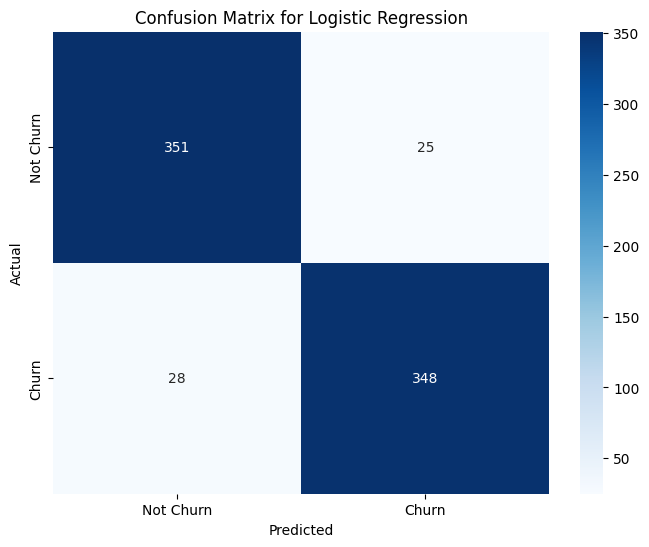

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       376
           1       0.93      0.93      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752

Training Random Forest...


2024/11/27 11:50:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


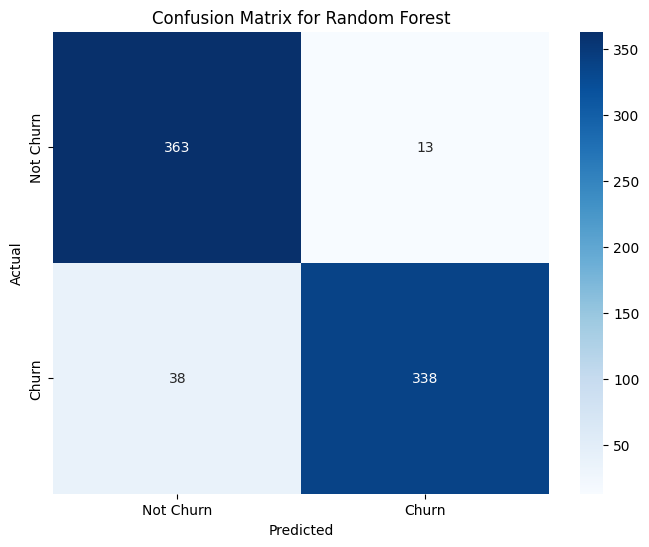

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.91      0.97      0.93       376
           1       0.96      0.90      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752

Training Support Vector Machine...


2024/11/27 11:50:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


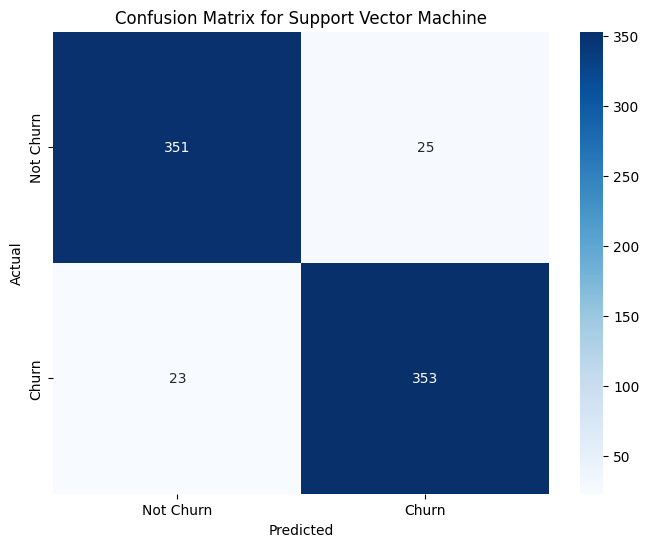

Classification Report for Support Vector Machine:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       376
           1       0.93      0.94      0.94       376

    accuracy                           0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752

Training K-Nearest Neighbors...


2024/11/27 11:50:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


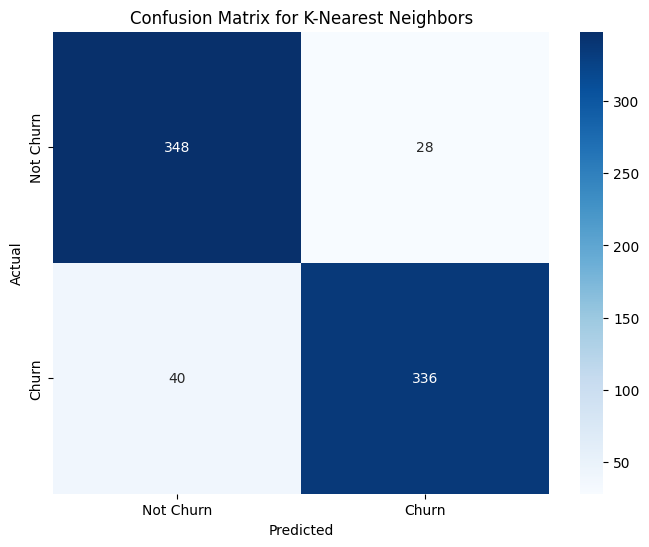

Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       376
           1       0.92      0.89      0.91       376

    accuracy                           0.91       752
   macro avg       0.91      0.91      0.91       752
weighted avg       0.91      0.91      0.91       752

Training Decision Tree...


2024/11/27 11:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


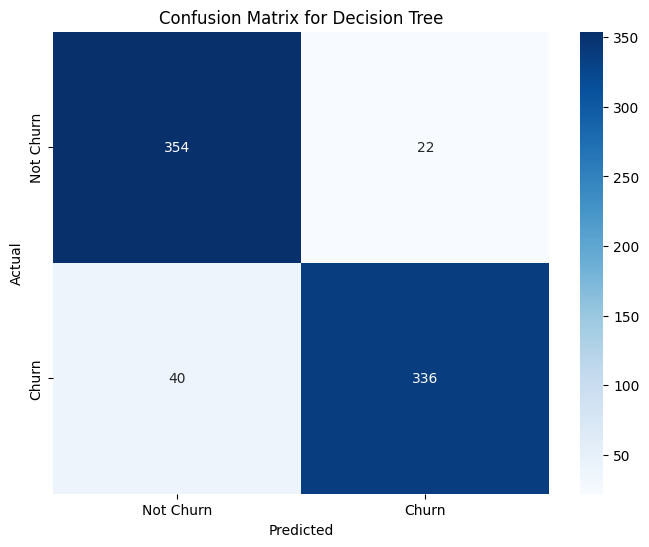

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       376
           1       0.94      0.89      0.92       376

    accuracy                           0.92       752
   macro avg       0.92      0.92      0.92       752
weighted avg       0.92      0.92      0.92       752

Training Gradient Boosting...


2024/11/27 11:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


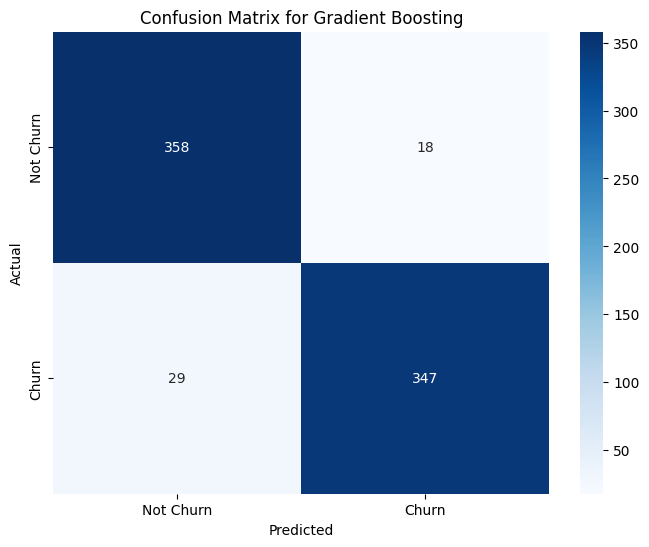

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       376
           1       0.95      0.92      0.94       376

    accuracy                           0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752

Training XGB...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/11/27 11:50:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


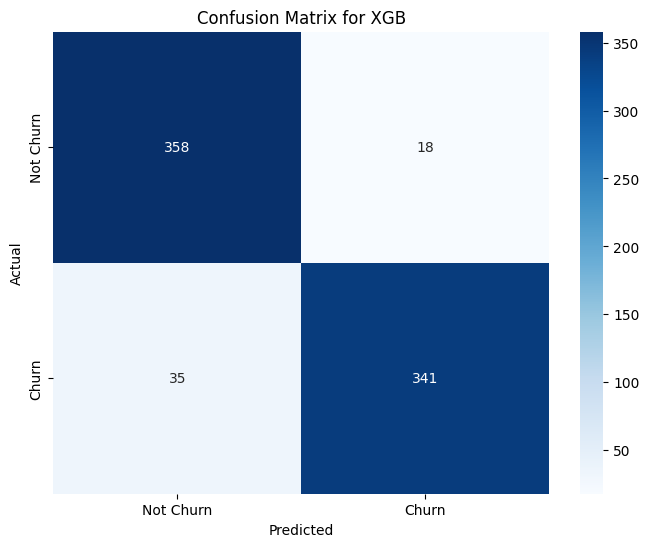

Classification Report for XGB:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       376
           1       0.95      0.91      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752

Training CatBoost...


2024/11/27 11:50:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


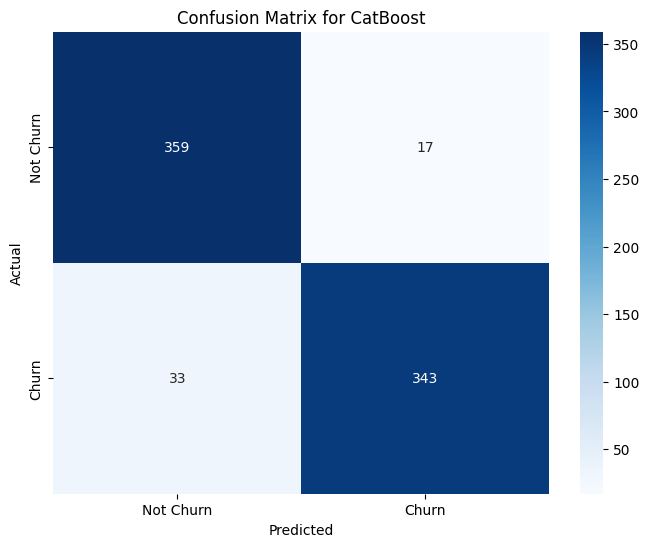

Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       376
           1       0.95      0.91      0.93       376

    accuracy                           0.93       752
   macro avg       0.93      0.93      0.93       752
weighted avg       0.93      0.93      0.93       752



,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
0,Logistic Regression,0.925622,0.929521,0.925621,0.929520
1,Random Forest,1.000000,0.932181,1.000000,0.932106
2,Support Vector Machine,0.930814,0.936170,0.930814,0.936170
3,K-Nearest Neighbors,0.963415,0.909574,0.963407,0.909551
4,Decision Tree,1.000000,0.917553,1.000000,0.917506
5,Gradient Boosting,0.954238,0.937500,0.954235,0.937487
6,XGB,0.997464,0.929521,0.997464,0.929485
7,CatBoost,0.983096,0.933511,0.983096,0.933481


In [ ]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.catboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    'XGB': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Dictionary to store scores
scores = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Train F1 Score": [],
    "Test F1 Score": []
}

# Set up MLflow experiment
#mlflow.set_experiment("ML_Model_Comparison")  # Set a custom experiment name

# Loop through models to train and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")

    with mlflow.start_run():  # Start a new MLflow run for each model
        # Log model parameters
        mlflow.log_param("model", model_name)

        train_features_name = f'{X_train=}'.split('=')[0]
        train_label_name = f'{y_train=}'.split('=')[0]
        mlflow.set_tag(key="train_features_name",value= train_features_name)
        mlflow.set_tag(key= "train_label_name",value=train_label_name)

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Log metrics to MLflow
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("train_f1_score", train_f1)
        mlflow.log_metric("test_f1_score", test_f1)

        # Add the results to the dictionary for later display
        scores["Model"].append(model_name)
        scores["Train Accuracy"].append(train_accuracy)
        scores["Test Accuracy"].append(test_accuracy)
        scores["Train F1 Score"].append(train_f1)
        scores["Test F1 Score"].append(test_f1)

        # Log the model (based on the model type)
        if model_name == 'XGB':
            mlflow.xgboost.log_model(model, "model")
        elif model_name == 'CatBoost':
            mlflow.catboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

        # Compute and display confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Not Churn", "Churn"],  # Update with your classes
                    yticklabels=["Not Churn", "Churn"])  # Update with your classes
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Print classification report
        print(f"Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_test_pred))
        print("=" * 180)  # Separator for clarity

# Create a DataFrame to display scores
scores_df = pd.DataFrame(scores)

# Display the scores table
scores_df

In [ ]:
#Reading Pandas Dataframe from mlflow
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments,filter_string="metrics.test_f1_score <1")
run_id = df_mlflow.loc[df_mlflow['metrics.test_f1_score'].idxmax()]['run_id']

In [ ]:
df_mlflow

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_f1_score,metrics.test_accuracy,metrics.train_accuracy,metrics.train_f1_score,params.model,tags.train_features_name,tags.train_label_name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name
0,df3534348dfb42aba0a51e3ad3afab97,0,FINISHED,file:///content/mlruns/0/df3534348dfb42aba0a51...,2024-11-27 11:50:51.670000+00:00,2024-11-27 11:50:59.916000+00:00,0.933481,0.933511,0.983096,0.983096,CatBoost,X_train,y_train,root,redolent-wolf-979,"[{""run_id"": ""df3534348dfb42aba0a51e3ad3afab97""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
1,82df7102d22c44119c5cdd2ad16bb4d5,0,FINISHED,file:///content/mlruns/0/82df7102d22c44119c5cd...,2024-11-27 11:50:48.677000+00:00,2024-11-27 11:50:51.664000+00:00,0.929485,0.929521,0.997464,0.997464,XGB,X_train,y_train,root,illustrious-loon-893,"[{""run_id"": ""82df7102d22c44119c5cdd2ad16bb4d5""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
2,2a40774c265943b68ef3ccaf40f5fac5,0,FINISHED,file:///content/mlruns/0/2a40774c265943b68ef3c...,2024-11-27 11:50:42.124000+00:00,2024-11-27 11:50:48.672000+00:00,0.937487,0.937500,0.954238,0.954235,Gradient Boosting,X_train,y_train,root,caring-cat-745,"[{""run_id"": ""2a40774c265943b68ef3ccaf40f5fac5""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
3,1f74f697abe049509cc4009709546bee,0,FINISHED,file:///content/mlruns/0/1f74f697abe049509cc40...,2024-11-27 11:50:39.253000+00:00,2024-11-27 11:50:42.118000+00:00,0.917506,0.917553,1.000000,1.000000,Decision Tree,X_train,y_train,root,burly-sow-622,"[{""run_id"": ""1f74f697abe049509cc4009709546bee""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
4,4aa55108094e41989405f2d60a3937b9,0,FINISHED,file:///content/mlruns/0/4aa55108094e41989405f...,2024-11-27 11:50:35.738000+00:00,2024-11-27 11:50:39.247000+00:00,0.909551,0.909574,0.963415,0.963407,K-Nearest Neighbors,X_train,y_train,root,enchanting-wolf-89,"[{""run_id"": ""4aa55108094e41989405f2d60a3937b9""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
5,7253d4fe55b24a99b4c1e63abe63f30e,0,FINISHED,file:///content/mlruns/0/7253d4fe55b24a99b4c1e...,2024-11-27 11:50:24.156000+00:00,2024-11-27 11:50:35.725000+00:00,0.936170,0.936170,0.930814,0.930814,Support Vector Machine,X_train,y_train,root,masked-loon-459,"[{""run_id"": ""7253d4fe55b24a99b4c1e63abe63f30e""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
6,369c6c4c335246a4bf18f7e8e8bb1e0b,0,FINISHED,file:///content/mlruns/0/369c6c4c335246a4bf18f...,2024-11-27 11:50:11.941000+00:00,2024-11-27 11:50:24.143000+00:00,0.932106,0.932181,1.000000,1.000000,Random Forest,X_train,y_train,root,whimsical-asp-932,"[{""run_id"": ""369c6c4c335246a4bf18f7e8e8bb1e0b""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
7,9a816de0235c4ad6a9580e6ef89a99fa,0,FINISHED,file:///content/mlruns/0/9a816de0235c4ad6a9580...,2024-11-27 11:50:01.995000+00:00,2024-11-27 11:50:11.925000+00:00,0.929520,0.929521,0.925622,0.925621,Logistic Regression,X_train,y_train,root,adorable-owl-854,"[{""run_id"": ""9a816de0235c4ad6a9580e6ef89a99fa""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
8,7e73a1a48e2145c099ccffc8aab1f655,264141077883485243,FINISHED,file:///content/mlruns/264141077883485243/7e73...,2024-11-27 11:38:20.789000+00:00,2024-11-27 11:38:31.798000+00:00,0.925681,0.925824,0.984621,0.984621,CatBoost,X_train,y_train,root,bald-finch-719,"[{""run_id"": ""7e73a1a48e2145c099ccffc8aab1f655""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...
9,e19009ef49fe4e86a33036962ecca6fd,264141077883485243,FINISHED,file:///content/mlruns/264141077883485243/e190...,2024-11-27 11:38:17.812000+00:00,2024-11-27 11:38:20.784000+00:00,0.920194,0.920330,0.997820,0.997820,XGB,X_train,y_train,root,likeable-ant-60,"[{""run_id"": ""e19009ef49fe4e86a33036962ecca6fd""...",LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...


In [ ]:
#let's call the model from the model registry ( in production stage)
import mlflow.pyfunc

logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(loaded_model)

# Predict on a Pandas DataFrame.

loaded_model.predict(X_test)

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: 2a40774c265943b68ef3ccaf40f5fac5



array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,